# Quality Assurance

An important step in the validation of food security data is to assess the extent to which the
data are consistent with assumptions of the measurement model. In data that meet those
assumptions, household raw score (the number of items affirmed by the household) is an
ordinal measure of the severity of food insecurity in the household, and the household severity
parameter is an interval-level measure of severity. Neither of these important measurement
traits is certain if model assumptions are not met.

This notebook presents basic concepts and mathematics underlying the `Rasch` model and describes
the model parameters and statistics used to assess food security survey data in this project.

## Rasch Model
By defining a probabilistic model that links the (unknown) measure of food insecurity to the
(observable) responses to experience-based questionnaires, it is possible to obtain estimates
of the former using data collected on any sample of individuals.

The simplest of such models that preserves all desirable qualities of a proper measurement
model is the `Rasch` model. In this model, the probability that a respondent
will report a given experience is a logistic function of the distance between the respondent’s
and the item’s positions on the severity scale:

$$Prob(x_{h,i} = 1|θ_h, β_i) =  \frac {e^{θ_h - β_i}}{1 + e^{θ_h - β_i}}$$

where $x_{ℎ,𝑖}$ is the response given by respondent *h* to item *i*, coded as 1 for “yes” and 0 for “no”.
The relative severity associated with each of the experiences (the parameters $β_i$
in the formula above) can be inferred from the frequency with which they are reported by a large sample of respondents, 
assuming that, all else being equal, more severe experiences are reported by fewer respondents. 
Once the severity of each experience is estimated, the severity of a respondent’s condition (the 𝜃ℎ parameter) can be computed
by noting how many of the items have been affirmed

In [1]:
import rpy2
import pandas as pd

In [2]:
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
# from pyper import R

%load_ext rpy2.ipython

utils = importr('utils')
# utils.install_packages('anthro')
pandas2ri.activate()

### Import Libraries and Load the data

In [3]:
%%R
library(tidyverse)
library(TAM)
library(WrightMap)

# Define the file path
file_path <- "../data/supervised_clean_data.csv"

# Define the regex pattern to select columns
regex_pattern <- '^fies'

# Read the CSV file while selecting columns using the regex pattern
df <- read_csv(file_path, col_types = cols(.default = "c"), col_select = matches(regex_pattern))

## Drop the fies_rawscore columns
df <- subset(df, select=-fies_rawscore)

# Convert the values to integers
df <- as.data.frame(lapply(df, as.integer))

dim(df)
head(df)



── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
New names:
• `` -> `...1`
  fies_worried fies_healthy fies_fewfoods fies_skipped fies_ateless fies_ranout
1            1            1             1            1            1           1
2            1            1             1            1            1           1
3            1            1             1            1            1           1
4            1            1             1            1            1           1
5            1            1             1            1            1           1
6            1            1             1            1            1           1
  fies_hungry fies_whlday
1    

Loading required package: CDM
Loading required package: mvtnorm
**********************************
** CDM 8.2-6 (2022-08-25 15:43:23)       
** Cognitive Diagnostic Models  **
**********************************

* TAM 4.1-4 (2022-08-28 16:03:54)


### Running the Rasch Model

In [4]:
%%R
# Running the Rasch model
rasch_model <- tam(df)
summary(rasch_model)

....................................................
Processing Data      2024-04-06 20:33:44 
    * Response Data: 3441 Persons and  8 Items 
    * Numerical integration with 21 nodes
    * Created Design Matrices   ( 2024-04-06 20:33:44 )
    * Calculated Sufficient Statistics   ( 2024-04-06 20:33:44 )
....................................................
Iteration 1     2024-04-06 20:33:44
E Step
M Step Intercepts   |----
  Deviance = 22696.6148
  Maximum item intercept parameter change: 0.382477
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter change: 0.256539
....................................................
Iteration 2     2024-04-06 20:33:44
E Step
M Step Intercepts   |---
  Deviance = 22139.9182 | Absolute change: 556.6966 | Relative change: 0.02514447
  Maximum item intercept parameter change: 0.146116
  Maximum item slope parameter change: 0
  Maximum regression parameter change: 0
  Maximum variance parameter ch

**Observation**
* Mean Rasch `reliability` was 0.752

### Understanding the Rasch Model

In [6]:
%%R
item_prop <- rasch_model$item
item_prop

                       item    N         M   xsi.item AXsi_.Cat1 B.Cat1.Dim1
fies_worried   fies_worried 3441 0.8892764 -3.3929841 -3.3929841           1
fies_healthy   fies_healthy 3441 0.9043883 -3.6425304 -3.6425304           1
fies_fewfoods fies_fewfoods 3441 0.8977042 -3.5286157 -3.5286157           1
fies_skipped   fies_skipped 3441 0.8517873 -2.8713622 -2.8713622           1
fies_ateless   fies_ateless 3441 0.8773612 -3.2142610 -3.2142610           1
fies_ranout     fies_ranout 3441 0.5396687 -0.2490513 -0.2490513           1
fies_hungry     fies_hungry 3441 0.5876199 -0.5803227 -0.5803227           1
fies_whlday     fies_whlday 3441 0.2938099  1.5063331  1.5063331           1


The number of **YES** answers, or, number of people who endorse a category increases monotonically with the item severity.

To see this, we can find the total number of people who endorsed the “yes” category for each `fies` item above.

The table provides the proportion who endorsed the higher category in the `M` column.

For instance, item Hls1 had 15.77% of people endorse the “agree” category (1= agree, 0= disagree). In the N column, we see that 317 people answered the item in total.

**The correlation between total number of "yes" per item and the estimated item severity can be computed as follows.**

In [7]:
%%R
# create a column in the item_prop object that has the total number of endorsements for each item
item_prop <- mutate(item_prop, total_endorsed =N*M)

cor(item_prop$xsi.item, item_prop$total_endorsed)

[1] -0.9968367


**Observation**

We see that the correlation between item severities and total endorsements per item is nearly perfect -.99. 

As the number of endorsements go down, the estimated severities of the item increase.

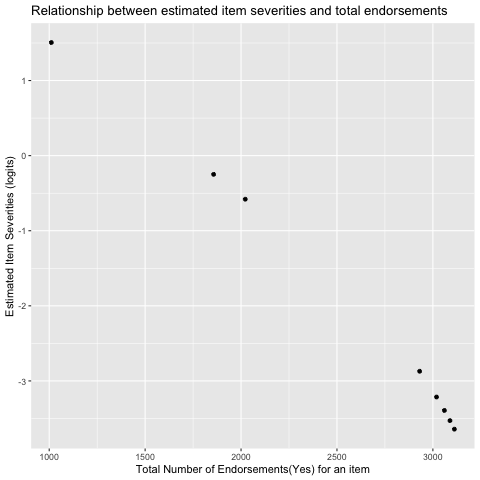

In [8]:
%%R
ggplot(item_prop, aes(x=total_endorsed, y=xsi.item)) + 
  geom_point() +
  ylab("Estimated Item Severities (logits)") +
  xlab("Total Number of Endorsements(Yes) for an item") +
  ggtitle("Relationship between estimated item severities and total endorsements")

### Item Severity

We’ll extract difficulties `(xsi)` from the `rasch_model` object

In [9]:
%%R
# Item difficulties
severities <- rasch_model$xsi
severities

                     xsi     se.xsi
fies_worried  -3.3929841 0.06735227
fies_healthy  -3.6425304 0.07131904
fies_fewfoods -3.5286157 0.06945831
fies_skipped  -2.8713622 0.06028390
fies_ateless  -3.2142610 0.06475117
fies_ranout   -0.2490513 0.04461139
fies_hungry   -0.5803227 0.04506776
fies_whlday    1.5063331 0.04826312


**Observation**
* In the result above, we can see the item severity in logits in the column `xsi` and the standard error for each item `se.xsi`. 
One way to think of what the standard error tells us is whether item severity may overlap or not.

* Higher `xsi` values indicate more severe items. For instance, item `fies_worried` is more severe than `fies_whlday`. The values are identified by constraining the mean of item severity to zero.

In [10]:
%%R
## Item difficulties vs their standard error
ggplot(severities, aes(x=xsi, y=se.xsi)) + geom_point() +
  ggtitle("Item severity and their standard error") +
  xlab("Estimated Item Severity") 
  ylab("Estimated Item Standard Errors")

$y
[1] "Estimated Item Standard Errors"

attr(,"class")
[1] "labels"


In [11]:
%%R
# Let's find out if the data fits the model.
fit <- tam.fit(rasch_model)
write.csv(fit$itemfit, file = "../data/fies_fit.csv",row.names=FALSE)
fit$itemfit

Item fit calculation based on 5 simulations
|**********|
|--------|
      parameter   Outfit    Outfit_t      Outfit_p  Outfit_pholm     Infit
1  fies_worried 1.098716  1.91375568  5.565138e-02  1.113028e-01 0.8659512
2  fies_healthy 1.528372  9.76554517  1.582585e-22  9.495511e-22 0.9750876
3 fies_fewfoods 1.576527 10.43484281  1.718980e-25  1.203286e-24 0.9068199
4  fies_skipped 0.743585 -7.72438572  1.123940e-14  5.619701e-14 0.8861048
5  fies_ateless 1.102442  2.38736770  1.696951e-02  5.090853e-02 0.8810933
6   fies_ranout 1.004754 -0.04776821  9.619010e-01  9.619010e-01 0.9861094
7   fies_hungry 1.077920  3.44090749  5.797667e-04  2.319067e-03 1.0315359
8   fies_whlday 1.781338 24.69594031 1.182470e-134 9.459759e-134 0.9836559
     Infit_t     Infit_p Infit_pholm
1 -3.2422528 0.001185888 0.009487102
2 -0.5304148 0.595824386 1.000000000
3 -2.1290281 0.033251933 0.166259667
4 -3.2000630 0.001373976 0.009617830
5 -3.0192018 0.002534417 0.015206500
6 -0.6420004 0.520872894 1.00000000

### Visualizing Item Fit

We can use default `WrightMap` functionality to plot item fit statistics. 
In the fit object, `itemfit` is a dataframe containing various fit statistics. 

We’ll plot `infit` with a lowerbound of .70 (in mean-square error units) and an upper bound of 1.1

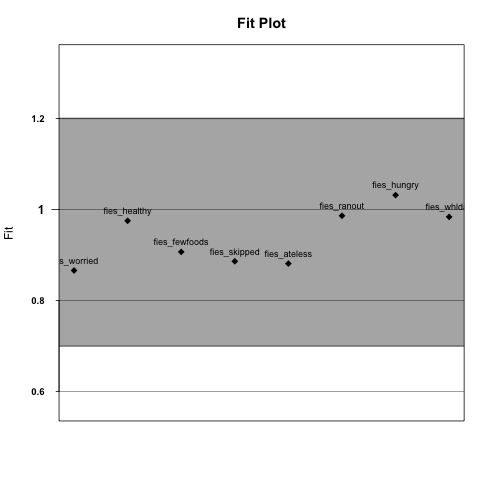

In [12]:
%%R
# Infit
infit <- fit$itemfit$Infit

upper_bound <- rep(x = 1.2, times =8) # this repeats 1.33 fifteen times
lower_bound <- rep(x = .70, times = 8) 

# running fitgraph
fitgraph(fitEst = infit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(df))

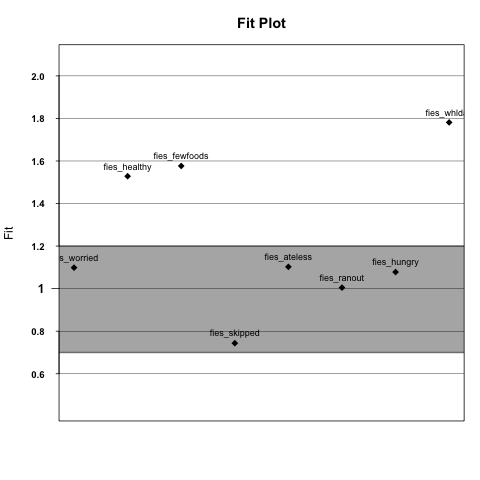

In [13]:
%%R
# # what about outfit?
outfit <- fit$itemfit$Outfit


fitgraph(fitEst = outfit, fitLB = lower_bound, fitUB = upper_bound, itemLabels = names(df))

**Observation**
* The weighted **infit** statistics for the FIES data in our study were within the acceptable range of 0.7–1.2.

### Summary of item infit statistics for round 6 survey datasets conducted in Nigeria in 2024

This section summarizes findings on data quality and consistency with assumptions of the
Rasch measurement model and presents the results obtained from the datasets collected.

In [14]:
fies_fit = pd.read_csv("../data/fies_fit.csv", index_col=False)
fies_fit

,parameter,Outfit,Outfit_t,Outfit_p,Outfit_pholm,Infit,Infit_t,Infit_p,Infit_pholm
0,fies_worried,1.098716,1.913756,5.565138e-02,1.113028e-01,0.865951,-3.242253,0.001186,0.009487
1,fies_healthy,1.528372,9.765545,1.582585e-22,9.495511e-22,0.975088,-0.530415,0.595824,1.000000
2,fies_fewfoods,1.576527,10.434843,1.718980e-25,1.203286e-24,0.906820,-2.129028,0.033252,0.166260
3,fies_skipped,0.743585,-7.724386,1.123940e-14,5.619701e-14,0.886105,-3.200063,0.001374,0.009618
4,fies_ateless,1.102442,2.387368,1.696951e-02,5.090853e-02,0.881093,-3.019202,0.002534,0.015207
5,fies_ranout,1.004754,-0.047768,9.619010e-01,9.619010e-01,0.986109,-0.642000,0.520873,1.000000
6,fies_hungry,1.077920,3.440907,5.797667e-04,2.319067e-03,1.031536,1.420207,0.155548,0.622190
7,fies_whlday,1.781338,24.695940,1.182470e-134,9.459759e-134,0.983656,-0.641585,0.521143,1.000000


### Observation

**Item Infit Statistic**

In spite of the wide range of cultures and languages in which the FIES-SM was administered
and the attendant challenges of translation, the fit of all the items to the measurement model
was remarkably good. 


**Infit statistics** 
* For each item were between 0.8 and 1.02.
* The highest mean infit (1.02) was for the `fies_hungry`
* The lowest mean infits were for `fies_ateless` (0.862) and `fies_worried`(0.867).



**Item Outfit Statistics**

Outfit statistics are sensitive to even a few cases with highly improbable response patterns. They
are useful primarily for identifying items that may be inconsistently understood by a small
proportion of respondents, but may also reflect just one or two careless responses or recordings
by the interviewer.

**Infit statistics** 

* For each item were between 0.72 and 1.73.
* The most severe item, `fies_whlday`, had the highest mean outfit (1.731).
* The lowest mean outfit were for `fies_skipped` (0.72) and `fies_ateless`(0.99).

### **Impact**
* The low infit shows that the items were most consistently associated with the latent trait measured by all of the
items.
* The outfit statistics computed for the 2024 round 6 application of the FIES for Nigeria
do not indicate  model misfit or distortion of severity estimates for respondents to warrant any change in the estimation procedure


Overall, 
* The weighted **infit** statistics for the FIES data in our study were within the acceptable range of 0.7–1.2, which verified that the FIES is a reliable and valid measure to assess food insecurity in this population.
* Mean Rasch Model `reliability` was 0.752. These levels of reliability for a scale comprising just eight items reflect reasonably good model fit.
